# Analysis of General Public graphs





In [12]:
import warnings
warnings.filterwarnings("ignore")
import glob
import os
import os.path as op
import sys
sys.path.append(
    '/Users/CN/Documents/Projects/Cambridge/cambridge_language_analysis/')

# Plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# Data Processing
import numpy as np
import pandas as pd
import scipy as sp
import datetime
import re
# import gensim
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import collections
import networkx as nx


In [2]:
# SemanticSpeechGraph functions
from compile_graphs_dataset import get_graphs, graph_properties, exclude_empty_graphs
from graph_analysis_functions import print_bidirectional_edges, print_parallel_edges, get_parallel_edges
from word_embedding_analysis import central_words

In [3]:
# --------------------- Import graphs ---------------------------------------
graph_dir = '/Users/CN/Dropbox/speech_graphs/all_tats'
output_figures = op.join(graph_dir, 'figures')

graphs, filelist = get_graphs(graph_dir)
graphs, filelist = exclude_empty_graphs(graphs, filelist, be_quiet=True)



Obtained 2861 graphs. Excluded 16 empty graphs. Kept 2845 graphs.


In [4]:
# --------------------- Import graph data ---------------------------------------
df = pd.read_csv(op.join(graph_dir, 'output/graph_data_normalised.csv'))

print('Described {0} graphs.\n{1} subjects described {2} ± {3} pictures.'.format(df.shape[0], len(df.subj.unique()), round(df.subj.value_counts().mean(),2), round(df.subj.value_counts().std(),2)))

# Make subj and tat categorical
df.subj = pd.Categorical(df.subj.astype('str'))
df.tat = pd.Categorical(df.tat.astype('str'))
df.tat = df.tat.cat.rename_categories({'8': '08'})
df.tat = df.tat.cat.reorder_categories(
    ['08', '10', '13', '19', '21', '24', '28', '30'])

Described 2845 graphs.
436 subjects described 6.53 ± 2.39 pictures.


# Plots

In [28]:
np.argwhere(np.isnan(df.nodes.values))
np.argwhere(np.isnan(df.cc_size_med_normZ.values))
np.argwhere(np.isnan(df.cc_size_mean_normZ.values))
np.argwhere(np.isnan(df.connected_components_normZ.values))

# df.connected_components_normZ[np.argwhere(np.isnan(df.connected_components_normZ.values))]

sp.stats.pearsonr(df.nodes[~np.isnan(df.cc_size_med_normZ.values)],df.cc_size_med_normZ[~np.isnan(df.cc_size_med_normZ.values)])
sp.stats.pearsonr(df.nodes[~np.isnan(df.cc_size_med_normZ.values)],df.cc_size_med_normZ[~np.isnan(df.cc_size_med_normZ.values)])

(0.32792165379194294, 1.3920129872616173e-71)

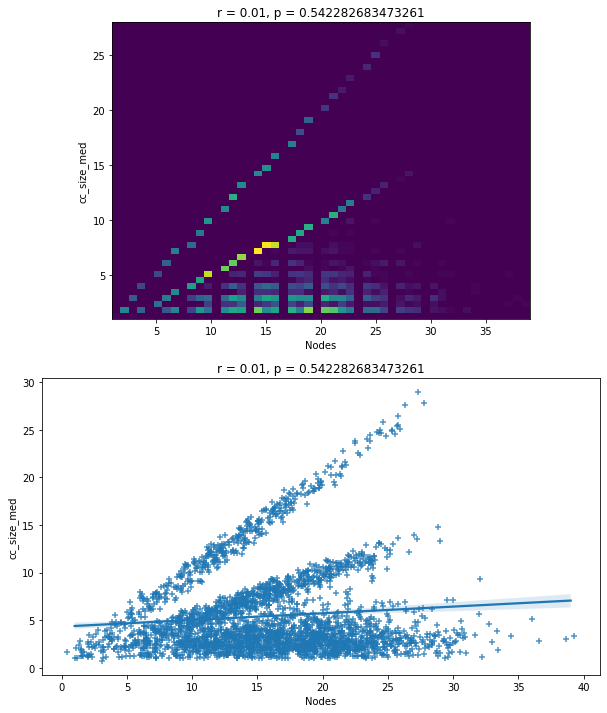

In [130]:
# ----------- Plot nodes vs connected component measures -----------
plot_variable = 'cc_size_med'
nans = np.isnan(df[plot_variable].values)
correlation = sp.stats.spearmanr(df.nodes[~nans],df[plot_variable][~nans])


fig = plt.figure(figsize=(10, 12))

ax = plt.subplot(2,1,1)
heatmap, xedges, yedges = np.histogram2d(df.nodes[~nans], df[plot_variable][~nans], bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.title('r = {}, p = {}'.format(round(correlation[0],2), correlation[1]))
plt.xlabel('Nodes')
plt.ylabel(plot_variable)

ax = plt.subplot(2,1,2)
sns.regplot(data=df[~nans], x="nodes", y=plot_variable, x_jitter=True, y_jitter=True, marker="+")
plt.title('r = {}, p = {}'.format(round(correlation[0],2), correlation[1]))
plt.xlabel('Nodes')
plt.ylabel(plot_variable)

output = op.join(output_figures, 'Nodes_vs_{}' +
                 '_{}'.format(plot_variable, str(datetime.date.today())))
plt.savefig(output)
plt.show(block=False)



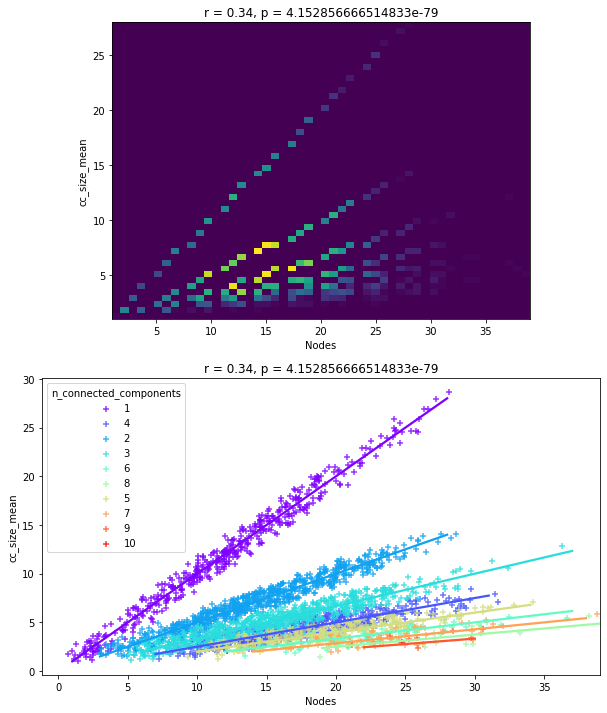

In [145]:
# ----------- Plot nodes vs edges -----------
plot_variable = 'cc_size_mean'
nans = np.isnan(df[plot_variable].values)
correlation = sp.stats.spearmanr(df.nodes[~nans],df[plot_variable][~nans])


fig = plt.figure(figsize=(10, 12))

ax = plt.subplot(2,1,1)
heatmap, xedges, yedges = np.histogram2d(df.nodes[~nans], df[plot_variable][~nans], bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.title('r = {}, p = {}'.format(round(correlation[0],2), correlation[1]))
plt.xlabel('Nodes')
plt.ylabel(plot_variable)

ax = plt.subplot(2,1,2)
df['nodes_over_edges'] = df.nodes / df.edges
groups = df.connected_components.unique()
colors = cm.rainbow(np.linspace(0, 1, len(groups)))
for t, c in zip(groups, colors):
    # plt.scatter(df[df.nodes_over_edges == t].nodes, df[df.nodes_over_edges == t].edges, color=c, label=t)
    sns.regplot(data=df[~nans][df.connected_components == t], x="nodes", y=plot_variable, color=c, x_jitter=True, y_jitter=True, marker="+", label=t)

ax.legend(title="n_connected_components")
plt.title('r = {}, p = {}'.format(round(correlation[0],2), correlation[1]))
plt.xlabel('Nodes')
plt.ylabel(plot_variable)

output = op.join(output_figures, 'Nodes_vs_{}' +
                 '_{}'.format(plot_variable, str(datetime.date.today())))
plt.savefig(output)
plt.show(block=False)



In [137]:
df.columns

Index(['Unnamed: 0', 'subj', 'tat', 'words', 'sentences', 'nodes', 'edges',
       'unconnected', 'average_total_degree', 'parallel_edges',
       'bidirectional_edges', 'lsc', 'lcc', 'L1', 'L2', 'L3',
       'sizes_connected_components', 'cc_size_mean', 'cc_size_med',
       'cc_size_sd', 'cc_size_max', 'connected_components',
       'max_degree_centrality', 'max_degree_node', 'max_indegree_centrality',
       'max_outdegree_centrality', 'max_indegree_centrality_value',
       'max_outdegree_centrality_value', 'mean_sentence_length',
       'mean_confidence', 'std_confidence', 'density', 'diameter',
       'average_shortest_path', 'clustering', 'consecutive_edges',
       'average_total_degree_normF', 'average_total_degree_normZ',
       'parallel_edges_normF', 'parallel_edges_normZ',
       'bidirectional_edges_normF', 'bidirectional_edges_normZ', 'lsc_normF',
       'lsc_normZ', 'lcc_normF', 'lcc_normZ', 'L1_normF', 'L1_normZ',
       'L2_normF', 'L2_normZ', 'L3_normF', 'L3_normZ', 

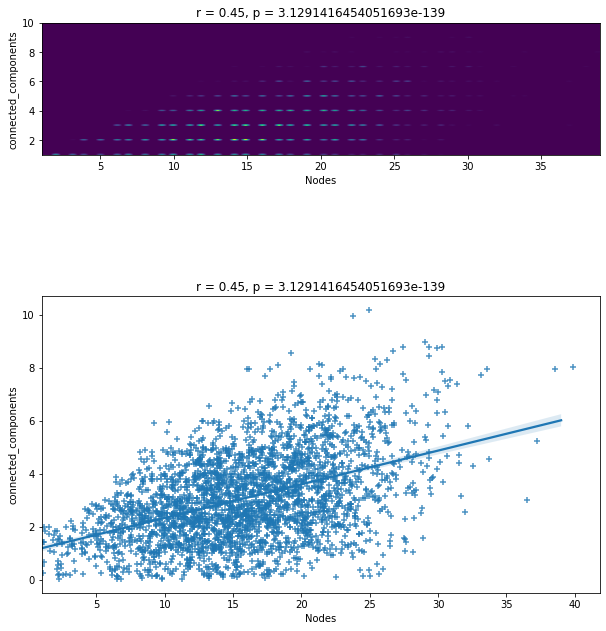

In [132]:
# ----------- Plot nodes vs edges -----------
plot_variable = 'connected_components'
nans = np.isnan(df[plot_variable].values)
correlation = sp.stats.spearmanr(df.nodes[~nans],df[plot_variable][~nans])


fig = plt.figure(figsize=(10, 12))

ax = plt.subplot(2,1,1)
heatmap, xedges, yedges = np.histogram2d(df.nodes[~nans], df[plot_variable][~nans], bins=100)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.title('r = {}, p = {}'.format(round(correlation[0],2), correlation[1]))
plt.xlabel('Nodes')
plt.ylabel(plot_variable)

ax = plt.subplot(2,1,2)
sns.regplot(data=df[~nans], x="nodes", y=plot_variable, x_jitter=True, y_jitter=True, marker="+")
plt.title('r = {}, p = {}'.format(round(correlation[0],2), correlation[1]))
plt.xlabel('Nodes')
plt.ylabel(plot_variable)

output = op.join(output_figures, 'Nodes_vs_{}' +
                 '_{}'.format(plot_variable, str(datetime.date.today())))
plt.savefig(output)
plt.show(block=False)
